<a href="https://colab.research.google.com/github/ridazaneb/IndoFashionCLIP/blob/main/results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This notebook compiles the app.py for the Streamlit dashboard as well as plotting graphs disucssing results from the best fine-tuned model.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import pandas as pd

# Load id2label
with open("/content/drive/MyDrive/IndoFashion/models/id2label.json") as f:
    id2label = json.load(f)
id2label = {int(k): v for k, v in id2label.items()}

# Load test data, handling potential multiple JSON objects or invalid JSON
try:
    with open("/content/drive/MyDrive/IndoFashion/data/test_data.json") as f:
        test_data = json.load(f)  # Try loading as a single JSON object
except json.JSONDecodeError:
    test_data = []  # Initialize an empty list to store multiple objects
    with open("/content/drive/MyDrive/IndoFashion/data/test_data.json") as f:
        for line in f:  # Read the file line by line
            try:
                data = json.loads(line)  # Try loading each line as JSON
                test_data.append(data)  # Append if successful
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line.strip()}, Error: {e}")

print("Number of test samples:", len(test_data))
print("First example:", test_data[0] if test_data else "Empty test data") # Check if list is empty



Number of test samples: 7500
First example: {'image_url': 'https://m.media-amazon.com/images/I/71NZQ-aaASL._AC_UL320_.jpg', 'image_path': 'images/test/0.jpeg', 'brand': 'TANTUJA BENGAL HANDLOOM', 'product_title': "(A Govt. of West Bengal Enterprises) Handloom Cotton Ethnic Wear For Women's-011H8B9699/BB 12 Black", 'class_label': 'saree'}


In [4]:
# ✅ Step 3: Hardcoded test results
results = {
    "class": [
        "blouse", "dhoti_pants", "dupattas", "gowns", "kurta_men",
        "leggings_and_salwars", "lehenga", "mojaris_men", "mojaris_women",
        "nehru_jackets", "palazzos", "petticoats", "saree", "sherwanis", "women_kurta"
    ],
    "precision": [0.96, 0.63, 0.68, 0.59, 0.87, 0.76, 0.78, 0.85, 0.75, 0.95, 0.65, 0.72, 0.69, 0.81, 0.53],
    "recall":    [0.88, 0.42, 0.51, 0.55, 0.72, 0.51, 0.90, 0.73, 0.87, 0.88, 0.91, 0.82, 0.84, 0.91, 0.67],
    "f1":        [0.92, 0.51, 0.58, 0.57, 0.79, 0.61, 0.84, 0.78, 0.81, 0.92, 0.76, 0.77, 0.75, 0.86, 0.59],
    "support":   [500]*15
}

df = pd.DataFrame(results)
df_sorted = df.sort_values(by="f1", ascending=False).reset_index(drop=True)
df_sorted

,class,precision,recall,f1,support
0,blouse,0.96,0.88,0.92,500
1,nehru_jackets,0.95,0.88,0.92,500
2,sherwanis,0.81,0.91,0.86,500
3,lehenga,0.78,0.90,0.84,500
4,mojaris_women,0.75,0.87,0.81,500
5,kurta_men,0.87,0.72,0.79,500
6,mojaris_men,0.85,0.73,0.78,500
7,petticoats,0.72,0.82,0.77,500
8,palazzos,0.65,0.91,0.76,500
9,saree,0.69,0.84,0.75,500


<ipython-input-6-4dcf92381b2b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="f1", y="class", data=df_sorted, palette="viridis")


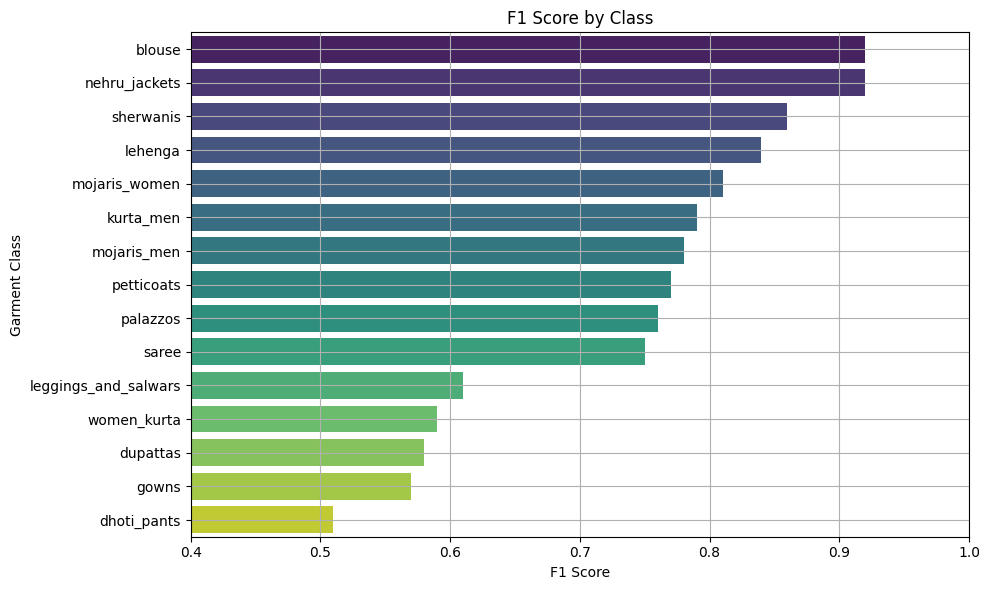

In [6]:
# ✅ Step 4: Plot F1 Score by Class
import seaborn as sns
import matplotlib.pyplot as plt
import os # Import the os module

# Create the 'results' directory if it doesn't exist
os.makedirs("/content/results", exist_ok=True)

plt.figure(figsize=(10,6))
sns.barplot(x="f1", y="class", data=df_sorted, palette="viridis")
plt.title("F1 Score by Class")
plt.xlabel("F1 Score")
plt.ylabel("Garment Class")
plt.xlim(0.4, 1.0)
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/results/f1_score.png")
plt.show()

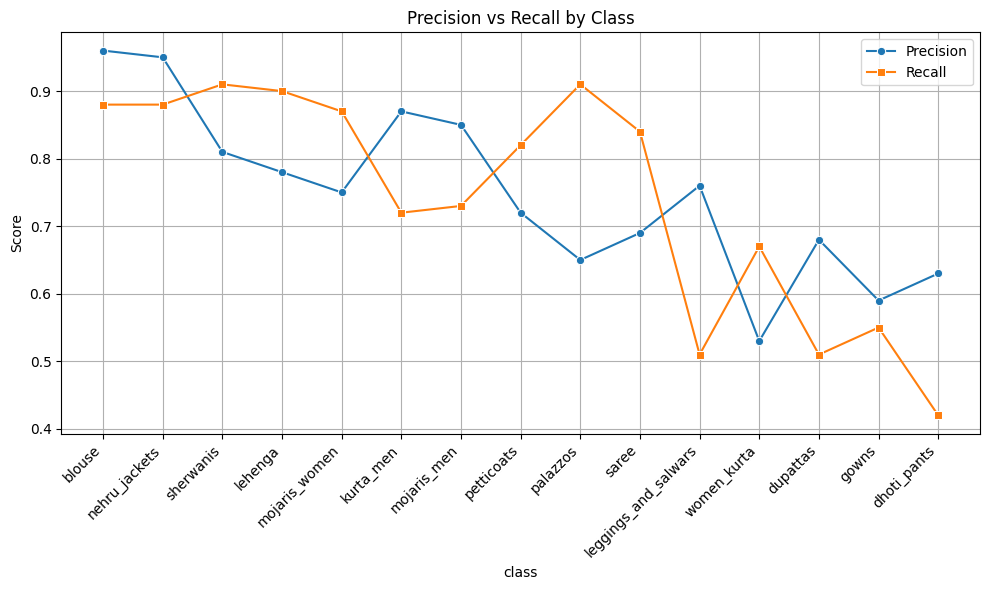

In [7]:
# ✅ Step 5: Precision vs Recall by Class
plt.figure(figsize=(10,6))
sns.lineplot(x="class", y="precision", data=df_sorted, label="Precision", marker="o")
sns.lineplot(x="class", y="recall", data=df_sorted, label="Recall", marker="s")
plt.xticks(rotation=45, ha='right')
plt.title("Precision vs Recall by Class")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/results/precision_recall.png")
plt.show()

In [23]:
!cp "/content/drive/MyDrive/IndoFashion/models/best.pt" "/content/clip_model.pt"
!cp "/content/drive/MyDrive/IndoFashion/models/id2label.json" "/content/id2label.json"


In [30]:
%%writefile app.py
import streamlit as st
st.set_page_config(page_title="IndoFashion CLIP Classifier", layout="centered")  # Must be first

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import CLIPVisionModel, CLIPProcessor
import clip
import json
import os

# -------- SETTINGS --------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/content/clip_model.pt"
ID2LABEL_PATH = "/content/id2label.json"

# -------- MODEL ARCHITECTURE --------
class CustomCLIP(nn.Module):
    def __init__(self, num_classes=15):
        super().__init__()
        self.backbone = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        features = outputs.last_hidden_state[:, 0, :]  # CLS token
        return self.classifier(features)

# -------- MODEL LOADING --------
@st.cache_resource
def load_everything():
    model = CustomCLIP(num_classes=15)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    clip_model, clip_preprocess = clip.load("ViT-B/32", device=DEVICE)
    clip_model.eval()

    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    with open(ID2LABEL_PATH) as f:
        id2label = json.load(f)
        id2label = {int(k): v for k, v in id2label.items()}

    return model, clip_model, clip_preprocess, processor, id2label

# -------- LOAD EVERYTHING --------
model, clip_model, clip_preprocess, processor, id2label = load_everything()

# -------- STREAMLIT UI --------
st.title("🌺 IndoFashion CLIP Classifier")
st.markdown("Upload a South Asian fashion image to get top 3 garment predictions. Try a prompt similarity test too!")

uploaded_file = st.file_uploader("Upload a fashion image", type=["jpg", "jpeg", "png"])
if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_container_width=True)

    with st.spinner("🔍 Predicting garment class..."):
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            logits = model(inputs.pixel_values)
            probs = F.softmax(logits, dim=1).squeeze()
            top_probs, top_idxs = torch.topk(probs, k=3)
            top_labels = [id2label[i.item()] for i in top_idxs]

    st.subheader("🎯 Top 3 Class Predictions")
    st.info("These predictions come from **my fine-tuned model**, trained only on IndoFashion images and 15 garment classes. This is what represents my custom training.")

    for label, prob in zip(top_labels, top_probs):
        st.write(f"**{label}** — {prob.item()*100:.2f}%")
        st.progress(prob.item())

# -------- PROMPT PLAYGROUND --------
st.markdown("---")
st.subheader("🧪 Prompt Engineering Playground")
st.info("This demo uses **OpenAI’s original CLIP** to compare the uploaded image with your custom prompt. It shows the **zero-shot matching power** of CLIP, without using my trained model.")

text_prompt = st.text_input("Try something like: 'a woman in a red silk saree'")
if uploaded_file and text_prompt:
    with st.spinner("🧠 Comparing image with prompt..."):
        image_input = clip_preprocess(image).unsqueeze(0).to(DEVICE)
        text_input = clip.tokenize([text_prompt]).to(DEVICE)
        with torch.no_grad():
            image_feat = clip_model.encode_image(image_input)
            text_feat = clip_model.encode_text(text_input)
            similarity = F.cosine_similarity(image_feat, text_feat).item()

    st.write(f"🧠 **Similarity Score**: `{similarity:.4f}`")
    if similarity > 0.3:
        st.success("Strong match!")
    elif similarity > 0.15:
        st.warning("Somewhat relevant")
    else:
        st.error("Weak match – try again!")

# -------- CAROUSEL OF RESULTS PLOTS --------
st.markdown("---")
st.subheader("📊 Evaluation Results Carousel")
st.info("These plots reflect the evaluation of my **fine-tuned model** on the IndoFashion test set. They summarize per-class performance metrics and training behavior.")

carousel_imgs = [
    ("/content/results/f1_score.png", "F1 Score by Class (Higher is Better)"),
    ("/content/results/precision_recall.png", "Precision vs Recall per Class"),
    # You can add more here as needed
]

idx = st.slider("Slide through evaluation visuals:", 0, len(carousel_imgs)-1)
img_path, img_caption = carousel_imgs[idx]
st.image(img_path, caption=img_caption, use_container_width=True)


Overwriting app.py


In [10]:
!pip install -q streamlit pyngrok transformers torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 878.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [31]:
# @title
from pyngrok import ngrok
ngrok.kill()

!streamlit run app.py &>/content/log.txt &
import time; time.sleep(10)
print("🔗", ngrok.connect(8501))


🔗 NgrokTunnel: "https://6879-34-23-69-35.ngrok-free.app" -> "http://localhost:8501"


In [19]:
from pyngrok import ngrok, conf
conf.get_default().region = "us"          # or your region
!ngrok authtoken 2wMKDmHaYBa1GjhPzYFvqgYduZh_2sraK1GftHFV3cAKW5MRd
public_url = ngrok.connect(8501, "http")
print("🔗 Public URL:", public_url)
!streamlit run app.py &>/content/log.txt &


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🔗 Public URL: NgrokTunnel: "https://199b-34-23-69-35.ngrok-free.app" -> "http://localhost:8501"


In [18]:
from pyngrok import ngrok, conf

# Terminate existing ngrok processes
ngrok.kill()

# Set region
conf.get_default().region = "us"

# Authenticate with your token
!ngrok authtoken 2wMKDmHaYBa1GjhPzYFvqgYduZh_2sraK1GftHFV3cAKW5MRd

# Start a new ngrok tunnel
public_url = ngrok.connect(8501, "http")
print("🔗 Public URL:", public_url)

# Run streamlit, redirecting output to a log file
!streamlit run app.py &>/content/log.txt &

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🔗 Public URL: NgrokTunnel: "https://835b-34-23-69-35.ngrok-free.app" -> "http://localhost:8501"
